In [1]:
# Load libraries

import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import stats
from scipy.stats import wilcoxon

#Add personal functions to python path
sys.path.append('/neurospin/meg/meg_tmp/WMP_Darinka_2015/Final_Python')
from jr.plot import base, gat_plot, pretty_gat, pretty_decod, pretty_slices
from jr.stats import gat_stats, parallel_stats

%matplotlib inline

In [2]:
def _my_wilcoxon(X):
    out = wilcoxon(X)
    return out[1]

In [6]:
####################Define important variables####################
#Paths
data_path = '/neurospin/meg/meg_tmp/WMP_Darinka_2015/Final_Decoding/IndividualResults/Rev2_DecLoc'
indResult_path = '/neurospin/meg/meg_tmp/WMP_Darinka_2015/Final_Decoding/IndividualResults/Rev2_DecLoc/Figures'
groupResult_path = '/neurospin/meg/meg_tmp/WMP_Darinka_2015/Final_Decoding/GroupResults/Rev2_DecLoc'

#List of parameters
ListSubject = ['ab140235', 'ad120287', 'ar140056', 'cc140058', 'eg140204', 
     'el130086', 'lm130479', 'ma130185', 'ro130031', 'sa130042', 'sb120316', 
     'th130177', 'ws140212']
ListCondition = [['AllVis_Train_WM', 'AllVis_Test_WM']]

chance = 0 #chance-level

ttp = [-0.2] #starting time point
toi = [[0.3, 0.6], [0.8, 2.532]] #training time points over which to average

In [7]:
####################Initialize results####################
all_scores = []
all_diagonals = []

In [8]:
####################Load data####################
for c, cond in enumerate(ListCondition):
    for s, subject in enumerate(ListSubject):
        
        fname = data_path + '/5Fold_' + subject + '_' + cond[0] + '_' + cond[1] + '-score.npy'
        score = np.load(fname)
        #score = score[:, 67:751]
        all_scores.append(score)
        
        fname = data_path + '/5Fold_' + subject + '_' + cond[0] + '_' + cond[1] + '-diagonal.npy'
        diagonal = np.load(fname)
        all_diagonals.append(diagonal)
    
        fname = data_path + '/5Fold_' + subject + '_' + cond[0] + '_' + cond[1] + '-time.npy'
        time = np.load(fname)
    
all_scores = np.array(all_scores) #shape: subjects*n_cond, training_times, testing_times
all_diagonals = np.array(all_diagonals)  

In [9]:
####################Reshape data####################
all_scores = np.reshape(all_scores, (len(ListCondition), len(ListSubject), score.shape[0], score.shape[1])) #n_cond, n_subj, training_times, testing_times
all_diagonals = np.reshape(all_diagonals, (len(ListCondition), len(ListSubject), diagonal.shape[0]))


In [10]:
np.shape(all_scores)

(1, 13, 751, 751)

In [11]:
####################Select subset of time window###################
#Identify the index
ind = np.where(time == ttp[0])
ind = int(ind[0][0])

#Cut all of the data
time = time[ind :]
all_diagonals = all_diagonals[:, :, ind :]
all_scores = all_scores[:, :, ind :, ind :]

In [12]:
####################Compute group averages####################
group_scores = np.zeros((len(ListCondition), all_scores.shape[2], all_scores.shape[3]))
sem_group_scores = np.zeros((len(ListCondition), all_scores.shape[2], all_scores.shape[3]))
group_diagonal = np.zeros((len(ListCondition), all_diagonals.shape[2]))
sem_group_diagonal = np.zeros((len(ListCondition), all_diagonals.shape[2]))

for c, cond in enumerate(ListCondition):
    group_scores[c, :, :] = np.mean(all_scores[c, :, :, :], 0)
    sem_group_scores[c, :, :] = stats.sem(all_scores[c, :, :, :], 0)

    group_diagonal[c, :] = np.mean(all_diagonals[c, :, :], 0)
    sem_group_diagonal[c, :] = stats.sem(all_diagonals[c, :, :], 0)

In [43]:
####################Compute time averages for diagonal####################
timeBins = [[0.1, 0.3], [0.3, 0.6], [0.6, 1.6], [1.6, 2.532]]
group_diagonal_AVG = np.zeros((len(ListCondition), len(timeBins), len(ListSubject)))
sem_group_diagonal_AVG = np.zeros((len(ListCondition), len(timeBins)))

for c, cond in enumerate(ListCondition):
    for tb, timebin in enumerate(timeBins):
        #Identify the index
        ind1 = np.where(time == timeBins[tb][0])
        ind1 = int(ind1[0][0])
        ind2 = np.where(time == timeBins[tb][1])
        ind2 = int(ind2[0][0])

        group_diagonal_AVG[c, tb, :] = np.mean(all_diagonals[c, :,  ind1 : ind2], 1)
        sem_group_diagonal_AVG[c, tb] = stats.sem(np.mean(all_diagonals[c, :, ind1 : ind2], 1), 0)

In [13]:
####################Compute stats for each condition separately####################
p_values_gat = np.zeros((len(ListCondition), all_scores.shape[2], all_scores.shape[3]))
p_values_gat_fdr = np.zeros((len(ListCondition), all_scores.shape[2], all_scores.shape[3]))
p_values_diagonal = np.zeros((len(ListCondition), all_diagonals.shape[2]))
p_values_diagonal_fdr = np.zeros((len(ListCondition), all_diagonals.shape[2]))
#p_values_group_classifier = np.zeros((len(ListCondition), len(toi), all_diagonals.shape[2]))
#p_values_group_classifier_fdr = np.zeros((len(ListCondition), len(toi), all_diagonals.shape[2]))
#p_values_group_classifier_AVG = np.zeros((len(ListCondition), len(toi),len(timeBins)))
#p_values_group_diagonal_AVG = np.zeros((len(ListCondition), len(timeBins)))

for c, cond in enumerate(ListCondition):
    p_values_gat[c, :, :] = parallel_stats(all_scores[c, :, :, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
    p_values_gat_fdr[c, :, :] = parallel_stats(all_scores[c, :, :, :] - chance, function = _my_wilcoxon, correction = 'FDR', n_jobs = -1)
    p_values_diagonal[c, :] = parallel_stats(all_diagonals[c, :, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
    p_values_diagonal_fdr[c, :] = parallel_stats(all_diagonals[c, :, :] - chance, function = _my_wilcoxon, correction = 'FDR', n_jobs = -1)
    
    #Get one-sided p-value
    p_values_diagonal[c, :] = p_values_diagonal[c, :]/2.
    p_values_diagonal_fdr[c, :] = p_values_diagonal_fdr[c, :]/2.
    
    #for tb, timebin in enumerate(timeBins):
        #p_values_group_diagonal_AVG[c, tb] = parallel_stats(group_diagonal_AVG[c, tb, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
        #p_values_group_diagonal_AVG[c, tb] = p_values_group_diagonal_AVG[c, t, tb]/2.     
        
    #for t, tp in enumerate(toi):
        #p_values_group_classifier[c, t, :] = parallel_stats(group_classifier[c, t, :, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
        #p_values_group_classifier_fdr[c, t, :] = parallel_stats(group_classifier[c, t, :, :] - chance, function = _my_wilcoxon, correction = 'FDR', n_jobs = -1)
        #p_values_group_classifier[c, t, :] = p_values_group_classifier[c, t, :]/2.
        #p_values_group_classifier_fdr[c, t, :] = p_values_group_classifier_fdr[c, t, :]/2.
        
        #for tb, timebin in enumerate(timeBins):
            #p_values_group_classifier_AVG[c, t, tb] = parallel_stats(group_classifier_AVG[c, t, tb, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
            #p_values_group_classifier_AVG[c, t, tb] = p_values_group_classifier_AVG[c, t, tb]/2.                       

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   33.7s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   34.0s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished


In [44]:
 ####################Compute stats for averaged diagonal####################
p_values_group_diagonal_AVG = np.zeros((len(ListCondition), len(timeBins)))

for c, cond in enumerate(ListCondition):
    for tb, timebin in enumerate(timeBins):
        p_values_group_diagonal_AVG[c, tb] = parallel_stats(group_diagonal_AVG[c, tb, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
        p_values_group_diagonal_AVG[c, tb] = p_values_group_diagonal_AVG[c, tb]/2.   

[Parallel(n_jobs=16)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Done   1 out of   1 | elapsed:    0.0s finished


ab140235
['AllVis_Train_WM', 'AllVis_Test_WM']


/home/dt237143/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Times New Roman'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


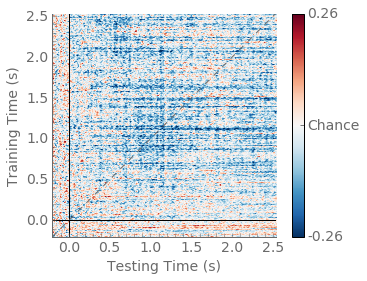

ad120287
['AllVis_Train_WM', 'AllVis_Test_WM']


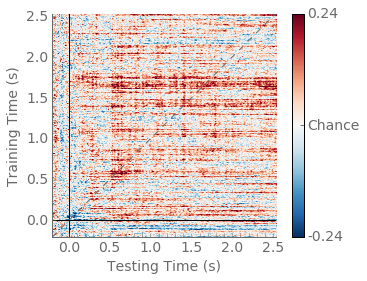

ar140056
['AllVis_Train_WM', 'AllVis_Test_WM']


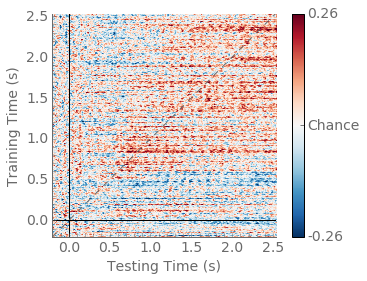

cc140058
['AllVis_Train_WM', 'AllVis_Test_WM']


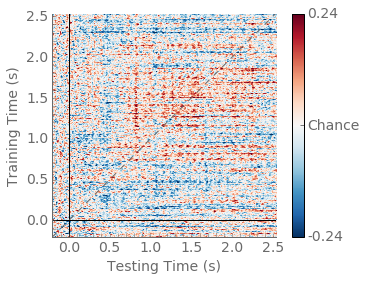

eg140204
['AllVis_Train_WM', 'AllVis_Test_WM']


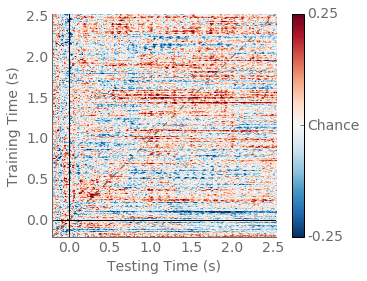

el130086
['AllVis_Train_WM', 'AllVis_Test_WM']


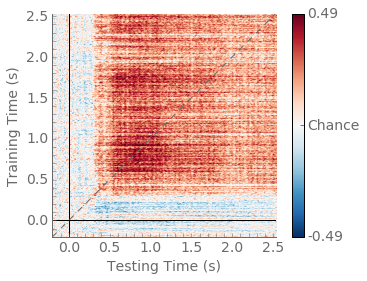

lm130479
['AllVis_Train_WM', 'AllVis_Test_WM']


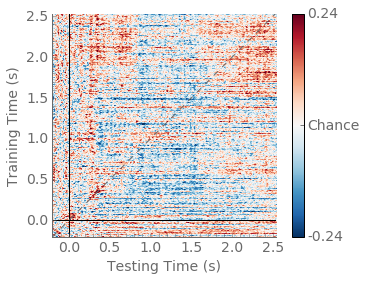

ma130185
['AllVis_Train_WM', 'AllVis_Test_WM']


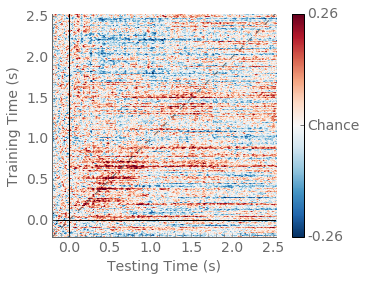

ro130031
['AllVis_Train_WM', 'AllVis_Test_WM']


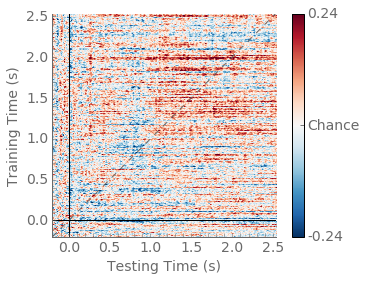

sa130042
['AllVis_Train_WM', 'AllVis_Test_WM']


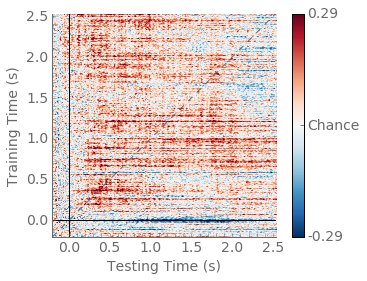

sb120316
['AllVis_Train_WM', 'AllVis_Test_WM']


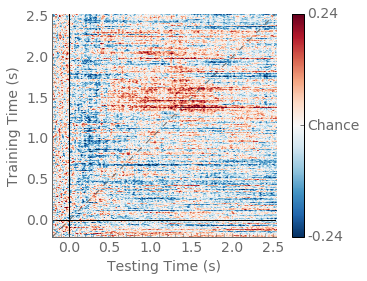

th130177
['AllVis_Train_WM', 'AllVis_Test_WM']


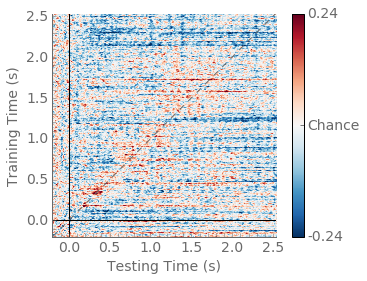

ws140212
['AllVis_Train_WM', 'AllVis_Test_WM']


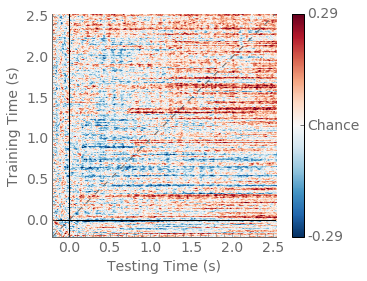

In [14]:
####################Plot original GAT####################
for c, cond in enumerate(ListCondition):
    for s, sub in enumerate(ListSubject):
        print(sub)
        print(cond)
        pretty_gat(all_scores[c, s, :, :], times = time, chance = chance, ax = None, sig = None, cmap = 'RdBu_r',
             clim = None, colorbar = True, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 250, diagonal = 'dimgray', test_times = None, smoothWindow=0)
        plt.show()

['AllVis_Train_WM', 'AllVis_Test_WM']


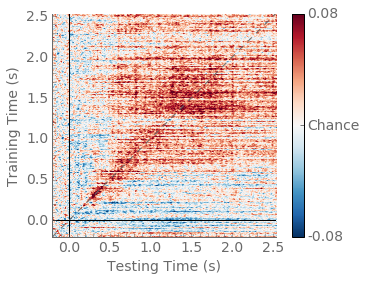

In [15]:
####################Plot original GAT####################
for c, cond in enumerate(ListCondition):
    print(cond)
    pretty_gat(group_scores[c, :, :], times = time, chance = chance, ax = None, sig = None, cmap = 'RdBu_r',
             clim = None, colorbar = True, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 250, diagonal = 'dimgray', test_times = None, smoothWindow=0)
    plt.show()

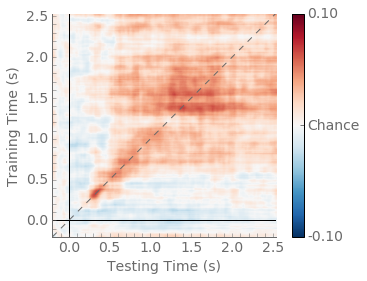

In [16]:
##### Plot GAT with uncorrected p values####################
for c, cond in enumerate(ListCondition):
    classLines = [None, None, toi, toi]
    pretty_gat(group_scores[c, :, :], times = time, chance = chance, ax = None, sig = None, cmap = 'RdBu_r',
             clim = [-0.1, 0.1], colorbar = True, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 250, diagonal = 'dimgray', test_times = None, smoothWindow=10)
    fname = groupResult_path + '/' + cond[0] + '_' + cond[1] + '-uncorrectedGAT.tif'
    plt.savefig(fname, format = 'tif', dpi = 300, bbox_inches = 'tight')
    plt.show()

['AllVis_Train_WM', 'AllVis_Test_WM']


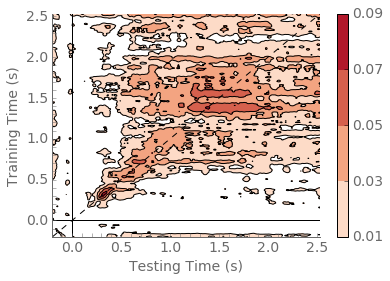

In [17]:
##### Plot GAT with uncorrected p values####################
for c, cond in enumerate(ListCondition):
    classLines = [None, None, toi, toi]
    print(cond)
    pretty_gat(group_scores[c, :, :], times = time, chance = chance, ax = None, sig = None, cmap = 'RdBu_r',
             clim = [-0.1, 0.1], colorbar = None, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 250, diagonal = 'k', test_times = None, smoothWindow=8, 
              contourPlot = True, steps = [0.01, 0.03, 0.05, 0.07, 0.09])
    fname = groupResult_path + '/' + cond[0] + '_' + cond[1] + '-uncorrectedGAT_contour.tif'
    plt.savefig(fname, format = 'tif', dpi = 300, bbox_inches = 'tight')
    plt.show()

['AllVis_Train_WM', 'AllVis_Test_WM']
[-0.196 -0.14  -0.132 -0.036 -0.032  0.04   0.08   0.096  0.152  0.156
  0.184  0.188  0.192  0.244  0.248  0.252  0.264  0.268  0.272  0.276
  0.28   0.288  0.292  0.296  0.3    0.304  0.308  0.312  0.316  0.32
  0.324  0.328  0.332  0.336  0.34   0.344  0.348  0.352  0.356  0.36
  0.364  0.368  0.384  0.392  0.396  0.4    0.404  0.408  0.412  0.416
  0.448  0.456  0.504  0.508  0.512  0.536  0.54   0.556  0.56   0.564
  0.568  0.592  0.596  0.6    0.604  0.608  0.612  0.648  0.656  0.66
  0.704  0.708  0.712  0.716  0.724  0.728  0.732  0.844  0.944  0.948
  0.952  0.984  1.008  1.06   1.064  1.068  1.08   1.084  1.092  1.1    1.112
  1.116  1.156  1.16   1.164  1.168  1.228  1.232  1.272  1.276  1.328
  1.356  1.36   1.364  1.368  1.372  1.38   1.384  1.388  1.392  1.396  1.4
  1.404  1.408  1.412  1.416  1.42   1.424  1.428  1.46   1.496  1.5    1.504
  1.508  1.512  1.52   1.54   1.548  1.552  1.564  1.568  1.572  1.576
  1.58   1.584  1.588  

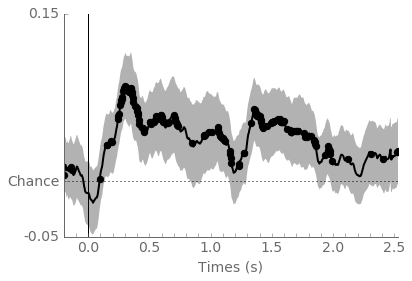

In [27]:
####################Plot decoding with uncorrected p values####################
#colors = ['dodgerblue', 'darkturquoise', 'darkred', 'crimson']
colors = [(0.0, 0.4470588235294118, 0.6980392156862745),
                 (0.0, 0.6196078431372549, 0.45098039215686275),
                 (0.8352941176470589, 0.3686274509803922, 0.0),
                 (0.8, 0.4745098039215686, 0.6549019607843137),
                 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
                 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

for c, cond in enumerate(ListCondition):
        print (cond)
        print(time[np.where(p_values_diagonal[c, :] < .05)])
        pretty_decod(all_diagonals[c, :, :], times=time, chance=chance, ax=None, sig=p_values_diagonal[c, :], width=20.,
                 color='k', fill=False, xlabel='Times (s)', sfreq=250, alpha=.02, scat=True, line=False, smoothWindow=16, lim = [-0.05, 0.15], thickness = 2, thicknessScat=40, schrift = 14)
        fname = groupResult_path + '/' + cond[0] + '_' + cond[1] + '-uncorrectedDiag_smooth.tif'
        plt.savefig(fname, format = 'tif', dpi = 300, bbox_inches = 'tight')
        
        plt.show()

['AllVis_Train_WM', 'AllVis_Test_WM']
[-0.196 -0.14  -0.132 -0.036 -0.032  0.04   0.08   0.096  0.152  0.156
  0.184  0.188  0.192  0.244  0.248  0.252  0.264  0.268  0.272  0.276
  0.28   0.288  0.292  0.296  0.3    0.304  0.308  0.312  0.316  0.32
  0.324  0.328  0.332  0.336  0.34   0.344  0.348  0.352  0.356  0.36
  0.364  0.368  0.384  0.392  0.396  0.4    0.404  0.408  0.412  0.416
  0.448  0.456  0.504  0.508  0.512  0.536  0.54   0.556  0.56   0.564
  0.568  0.592  0.596  0.6    0.604  0.608  0.612  0.648  0.656  0.66
  0.704  0.708  0.712  0.716  0.724  0.728  0.732  0.844  0.944  0.948
  0.952  0.984  1.008  1.06   1.064  1.068  1.08   1.084  1.092  1.1    1.112
  1.116  1.156  1.16   1.164  1.168  1.228  1.232  1.272  1.276  1.328
  1.356  1.36   1.364  1.368  1.372  1.38   1.384  1.388  1.392  1.396  1.4
  1.404  1.408  1.412  1.416  1.42   1.424  1.428  1.46   1.496  1.5    1.504
  1.508  1.512  1.52   1.54   1.548  1.552  1.564  1.568  1.572  1.576
  1.58   1.584  1.588  

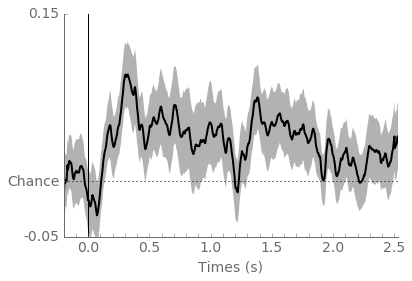

In [26]:
####################Plot decoding with uncorrected p values####################
#colors = ['dodgerblue', 'darkturquoise', 'darkred', 'crimson']
colors = [(0.0, 0.4470588235294118, 0.6980392156862745),
                 (0.0, 0.6196078431372549, 0.45098039215686275),
                 (0.8352941176470589, 0.3686274509803922, 0.0),
                 (0.8, 0.4745098039215686, 0.6549019607843137),
                 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
                 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

for c, cond in enumerate(ListCondition):
        print (cond)
        print(time[np.where(p_values_diagonal[c, :] < .05)])
        pretty_decod(all_diagonals[c, :, :], times=time, chance=chance, ax=None, sig=p_values_diagonal_fdr[c, :], width=20.,
                 color='k', fill=False, xlabel='Times (s)', sfreq=250, alpha=.02, scat=True, line=False, smoothWindow=8, lim = [-0.05, 0.15], thickness = 2, thicknessScat=40, schrift = 14)
        fname = groupResult_path + '/' + cond[0] + '_' + cond[1] + '-correctedDiag_smooth.tif'
        plt.savefig(fname, format = 'tif', dpi = 300, bbox_inches = 'tight')
        
        plt.show()

['AllVis_Train_WM', 'AllVis_Test_WM']
(0.040214486631745469, 1)
0.0132018320731
(0.061897957365046698, 1)
0.0189722031856
(0.043045563343109113, 1)
0.0226604929505
(0.026445342872017077, 1)
0.015932777188
0.00655180705502
0.00438731653005
0.0115649012487
0.0502625864045


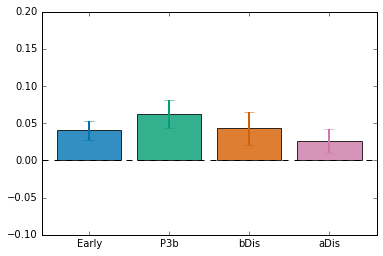

In [45]:
####################Plot diagonal in time bins####################
#Load important libraries
import matplotlib.pyplot as plt

#Define important variables
n_bins = len(timeBins)
font = {'fontname': 'Arial', 'fontsize': 14}

colors_blind = [(0.0, 0.4470588235294118, 0.6980392156862745),
                 (0.0, 0.6196078431372549, 0.45098039215686275),
                 (0.8352941176470589, 0.3686274509803922, 0.0),
                 (0.8, 0.4745098039215686, 0.6549019607843137),
                 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
                 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
               (0.0, 0.4470588235294118, 0.6980392156862745),
               (0.0, 0.6196078431372549, 0.45098039215686275),
                (0.8352941176470589, 0.3686274509803922, 0.0),]

xLabels = ['Early', 'P3b', 'bDis', 'aDis']

x = np.arange(n_bins)
index = np.arange(n_bins)

for c, cond in enumerate(ListCondition):
    ax = plt.gca()
    print(cond)
        
    ax.bar(x, np.mean(group_diagonal_AVG[c, :, :], 1), alpha = 0.8, color = colors_blind)
        
    print(np.mean(group_diagonal_AVG[c, 0, :]), 1)
    print(sem_group_diagonal_AVG[c, 0])
        
    print(np.mean(group_diagonal_AVG[c, 1, :]), 1)
    print(sem_group_diagonal_AVG[c, 1])
    
    print(np.mean(group_diagonal_AVG[c, 2, :]), 1)
    print(sem_group_diagonal_AVG[c, 2])
    
    print(np.mean(group_diagonal_AVG[c, 3, :]), 1)
    print(sem_group_diagonal_AVG[c, 3])
        
    print(p_values_group_diagonal_AVG[c, 0])
    print(p_values_group_diagonal_AVG[c, 1])
    print(p_values_group_diagonal_AVG[c, 2])
    print(p_values_group_diagonal_AVG[c, 3])
        
    for pos, y, err, color in zip(x, np.mean(group_diagonal_AVG[c, :, :], 1), sem_group_diagonal_AVG[c, :], colors_blind):
        ax.errorbar(pos + 0.4, y, err, lw = 2, capsize = 5, color = color)

    #Plot chance level
    plt.axhline(0.0, color = 'k', ls = '--')

    #Take care of axes
    ax.margins(0.05) #spacing at the 
    ax.set_xticks(index + 0.4)
    ax.set_xticklabels(xLabels)
    ax.set_ylim([-0.1, 0.2])
    plt.show()